<a href="https://colab.research.google.com/github/MartonJToth/DL-Clustering/blob/master/DL_Clustering_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Szükséges könyvtárak telepítése

In [0]:
# Lab based on the work of Yuefeng Zhang
# https://towardsdatascience.com/deep-clustering-for-financial-market-segmentation-2a41573618cf
# Origianl paper:
# https://arxiv.org/pdf/1511.06335.pdf
# Data:
# https://www.kaggle.com/arjunbhasin2013/ccdata/data


!pip install Pandas
!pip install scikit-learn

Adatok letöltése

In [0]:
!wget http://cg.iit.bme.hu/~tmarton/deeplearning/ccdata.zip
!unzip ccdata.zip


Importok

In [0]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn as sklearn
import sklearn.cluster
from sklearn.cluster import KMeans
import keras as keras
from IPython.display import Image
from keras import backend as K
import numpy as np

from time import time
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics

np.random.seed(10)

Adatok megnyitása és megtekintése

Egyedi azonosító eltávolítása

Adatok átskálázása 0-1 tartományba

Üres mezők kitöltése

Encoder-Decoder struktúra felépítése

In [0]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    
    



    
    
    return autoencoder_model, encoder_model

In [0]:
data_x.dtypes

In [0]:
x = data_x.values
x.shape

In [0]:
n_clusters = 3 # 3 - 0.291, 4 - 0.280, 5 - 0.228, 6 - 0.227, 10 - 0.192
n_epochs   = 20#100
batch_size = 128
save_dir = './'

KMenas klaszterezés az összehasonlítás kedvéért

Tanítás inicializálása

In [0]:
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size

In [0]:
dims

In [0]:
autoencoder, encoder = autoencoder(dims, init=init)

Encoder-Decoder struktúra tanítása

Clustering Layer

https://arxiv.org/pdf/1511.06335.pdf

In [0]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Új modell Encoder és Clustering

Új hálózat tanítása

In [0]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [0]:
y_pred_last = np.copy(y_pred)

In [0]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [0]:
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

In [0]:
tol = 0.001 # tolerance threshold to stop training

In [0]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Modell kiértékelése és kirajzolás

In [0]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [0]:
data_all = data_x.copy()
data_all['cluster'] = y_pred
data_all.head()
data_all['cluster'].value_counts()

In [0]:
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x)
x_embedded.shape

Modell újraépítése a Decoder ággal

In [0]:
# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [0]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

In [0]:
# evaluation of model prediction 
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [0]:
data_all['cluster'] = y_pred
data_all['cluster'].value_counts()

2    4054
1    3025
0    1871
Name: cluster, dtype: int64

In [0]:
data_cluster_0 = data_all[data_all['cluster'] == 0]
data_cluster_0.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.0
mean,0.016096,0.821841,0.035023,0.026373,0.028575,0.005486,0.738224,0.344804,0.498074,0.018996,0.005614,0.059734,0.164624,0.043696,0.003164,0.636198,0.914484,0.0
std,0.039056,0.242592,0.069924,0.069990,0.052426,0.029987,0.299606,0.399685,0.381227,0.067451,0.028025,0.079809,0.134113,0.081528,0.007877,0.314945,0.236188,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008347,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.001684,0.636364,0.006311,0.000000,0.001708,0.000000,0.500000,0.000000,0.083333,0.000000,0.000000,0.019553,0.065109,0.008533,0.001667,0.400000,1.000000,0.0
50%,0.004811,1.000000,0.015294,0.003368,0.013444,0.000000,0.833333,0.083333,0.500000,0.000000,0.000000,0.033520,0.131886,0.019992,0.002144,0.666667,1.000000,0.0
75%,0.013489,1.000000,0.037522,0.025586,0.033341,0.000000,1.000000,0.750000,0.888889,0.000000,0.000000,0.067039,0.232053,0.045514,0.002438,1.000000,1.000000,0.0
max,0.707829,1.000000,1.000000,1.000000,0.688764,0.579086,1.000000,1.000000,1.000000,0.611111,0.504065,1.000000,1.000000,1.000000,0.208288,1.000000,1.000000,0.0


In [0]:
data_cluster_1 = data_all[data_all['cluster'] == 1]
data_cluster_1.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.0
mean,0.100715,0.930515,0.031649,0.018751,0.035030,0.016929,0.841322,0.265088,0.737629,0.073248,0.022874,0.075618,0.156158,0.037542,0.014971,0.035428,0.938733,1.0
std,0.123385,0.190148,0.042238,0.036396,0.048033,0.043801,0.193607,0.319890,0.257770,0.127480,0.055436,0.082458,0.126744,0.055040,0.039142,0.075996,0.196821,0.0
min,0.000000,0.000000,0.000245,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008347,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.016511,1.000000,0.007954,0.000000,0.010458,0.000000,0.666667,0.000000,0.500000,0.000000,0.000000,0.030726,0.048414,0.009392,0.002432,0.000000,1.000000,1.0
50%,0.059105,1.000000,0.017587,0.004410,0.020594,0.000000,0.916667,0.111111,0.833333,0.000000,0.000000,0.047486,0.115192,0.021303,0.005883,0.000000,1.000000,1.0
75%,0.133242,1.000000,0.039278,0.023474,0.042282,0.016426,1.000000,0.444444,1.000000,0.111111,0.024390,0.089385,0.232053,0.043434,0.014451,0.000000,1.000000,1.0
max,1.000000,1.000000,0.663541,0.651291,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,0.969274,1.000000,0.800994,1.000000,0.400000,1.000000,1.0


In [0]:
data_cluster_2 = data_all[data_all['cluster'] == 2]
data_cluster_2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.0
mean,0.098792,0.863123,0.005384,0.005924,0.001008,0.030682,0.114066,0.090029,0.024294,0.135482,0.038653,0.006719,0.135077,0.027258,0.011466,0.019302,0.907581,2.0
std,0.108488,0.257014,0.013631,0.016153,0.004548,0.048032,0.156192,0.146769,0.065091,0.143076,0.061509,0.020035,0.109392,0.042049,0.029186,0.053428,0.234060,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.022370,0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048414,0.006304,0.002495,0.000000,1.000000,2.0
50%,0.064076,1.000000,0.000342,0.000000,0.000000,0.010816,0.083333,0.000000,0.000000,0.111111,0.016260,0.002793,0.098497,0.013220,0.005384,0.000000,1.000000,2.0
75%,0.133864,1.000000,0.005098,0.005196,0.000000,0.041839,0.166667,0.108333,0.000000,0.222222,0.048780,0.008380,0.198664,0.029506,0.011661,0.000000,1.000000,2.0
max,0.801245,1.000000,0.289868,0.348738,0.133333,0.555698,0.750000,0.750000,0.333333,1.000000,1.000000,0.863128,0.766277,0.577122,0.798778,0.444444,1.000000,2.0


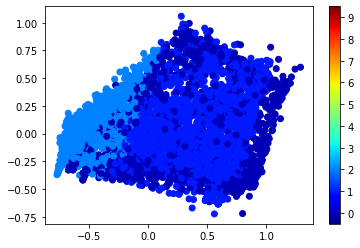

In [0]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

x_pca.shape

vis_x = x_pca[:, 0]
vis_y = x_pca[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()
